In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load Data ---
df = pd.read_csv('/kaggle/input/tbx11k-simplified/tbx11k-simplified/data.csv')
image_dir = '/kaggle/input/tbx11k-simplified/tbx11k-simplified/images'

def load_and_preprocess_image(fname, img_size=(128, 128)):
    img_path = os.path.join(image_dir, fname)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, img_size)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    img = np.stack([img] * 3, axis=-1)  # Convert grayscale to 3 channels
    img = img / 255.0
    return img

images, tb_labels, bbox_labels, severity_labels, sources = [], [], [], [], []

for _, row in df.iterrows():
    img = load_and_preprocess_image(row['fname'])
    if img is not None:
        images.append(img)
        tb_labels.append(1 if row['target'] == 'tb' else 0)
        bbox = eval(row['bbox']) if row['bbox'] != 'none' else {'xmin': 0, 'ymin': 0, 'width': 0, 'height': 0}
        bbox_labels.append([bbox['xmin'], bbox['ymin'], bbox['width'], bbox['height']])
        if row['tb_type'] == 'active_tb':
            severity_labels.append(2)
        elif row['tb_type'] == 'latent_tb':
            severity_labels.append(1)
        else:
            severity_labels.append(0)
        sources.append(row['source'])

2025-07-04 07:30:15.278781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751614215.488471      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751614215.547104      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
X = np.array(images)
y_tb = to_categorical(tb_labels, num_classes=2)
y_bbox = np.array(bbox_labels)
y_severity = to_categorical(severity_labels, num_classes=3)
sources = np.array(sources)

# --- Step 2: Split Data ---
X_train = X[sources == 'train']
X_val = X[sources == 'val']
y_tb_train = y_tb[sources == 'train']
y_tb_val = y_tb[sources == 'val']
y_bbox_train = y_bbox[sources == 'train']
y_bbox_val = y_bbox[sources == 'val']
y_severity_train = y_severity[sources == 'train']
y_severity_val = y_severity[sources == 'val']

# --- Step 3: Build Model ---
input_img = Input(shape=(128, 128, 3))
base = ResNet50(include_top=False, weights='imagenet', input_tensor=input_img)
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

tb_output = Dense(2, activation='softmax', name='tb_output')(x)
bbox_output = Dense(4, activation='linear', name='bbox_output')(x)
severity_output = Dense(3, activation='softmax', name='severity_output')(x)

model = Model(inputs=input_img, outputs=[tb_output, bbox_output, severity_output])


I0000 00:00:1751614391.185437      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751614391.186226      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# --- Step 4: Compile Model ---
model.compile(
    optimizer='adam',
    loss={
        'tb_output': 'binary_crossentropy',
        'bbox_output': 'mean_squared_error',
        'severity_output': 'categorical_crossentropy'
    },
    loss_weights={
        'tb_output': 2.0,
        'bbox_output': 0.5,
        'severity_output': 1.5
    },
    metrics={
        'tb_output': ['accuracy', 'AUC'],
        'bbox_output': 'mse',
        'severity_output': 'accuracy'
    }
)

# --- Step 5: Training ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train,
    {'tb_output': y_tb_train, 'bbox_output': y_bbox_train, 'severity_output': y_severity_train},
    validation_data=(X_val, {'tb_output': y_tb_val, 'bbox_output': y_bbox_val, 'severity_output': y_severity_val}),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/50


I0000 00:00:1751614455.810804     100 service.cc:148] XLA service 0x78eb800066a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751614455.811458     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751614455.811483     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751614460.470405     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/216 ━━━━━━━━━━━━━━━━━━━━ 4:22:02 73s/step - bbox_output_loss: 1633.0487 - bbox_output_mse: 1633.0487 - loss: 822.0146 - severity_output_accuracy: 0.1250 - severity_output_loss: 2.2050 - tb_output_AUC: 0.2529 - tb_output_accuracy: 0.3438 - tb_output_loss: 1.0914

I0000 00:00:1751614479.165231     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


216/216 ━━━━━━━━━━━━━━━━━━━━ 132s 273ms/step - bbox_output_loss: 1827.2278 - bbox_output_mse: 1827.2356 - loss: 915.9008 - severity_output_accuracy: 0.8425 - severity_output_loss: 0.8459 - tb_output_AUC: 0.9026 - tb_output_accuracy: 0.8728 - tb_output_loss: 0.5069 - val_bbox_output_loss: 6934.6880 - val_bbox_output_mse: 6744.5942 - val_loss: 3382.2566 - val_severity_output_accuracy: 0.8381 - val_severity_output_loss: 2.2335 - val_tb_output_AUC: 0.8381 - val_tb_output_accuracy: 0.8381 - val_tb_output_loss: 3.4269
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 30s 140ms/step - bbox_output_loss: 1263.5555 - bbox_output_mse: 1263.5483 - loss: 633.0910 - severity_output_accuracy: 0.9028 - severity_output_loss: 0.5731 - tb_output_AUC: 0.9732 - tb_output_accuracy: 0.9438 - tb_output_loss: 0.2287 - val_bbox_output_loss: 4117.4829 - val_bbox_output_mse: 3974.2883 - val_loss: 1989.3491 - val_severity_output_accuracy: 0.8381 - val_severity_output_loss: 0.7474 - val_tb_output_AUC: 0.8380 - val_tb_output_

60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step

--- TB Classification ---
Accuracy: 0.962807752750131
Precision: 0.8838709677419355
Recall: 0.8867313915857605
F1-Score: 0.8852988691437803
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1600
           1       0.88      0.89      0.89       309

    accuracy                           0.96      1909
   macro avg       0.93      0.93      0.93      1909
weighted avg       0.96      0.96      0.96      1909


--- BBox Regression ---
MSE: 1286.879156192374

--- Severity Classification ---
Accuracy: 0.9350445259298061
Precision: 0.9122941745877557
Recall: 0.9350445259298061
F1-Score: 0.922423594933947
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1600
           1       0.00      0.00      0.00        61
           2       0.71      0.89      0.79       248

    accuracy                 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:13

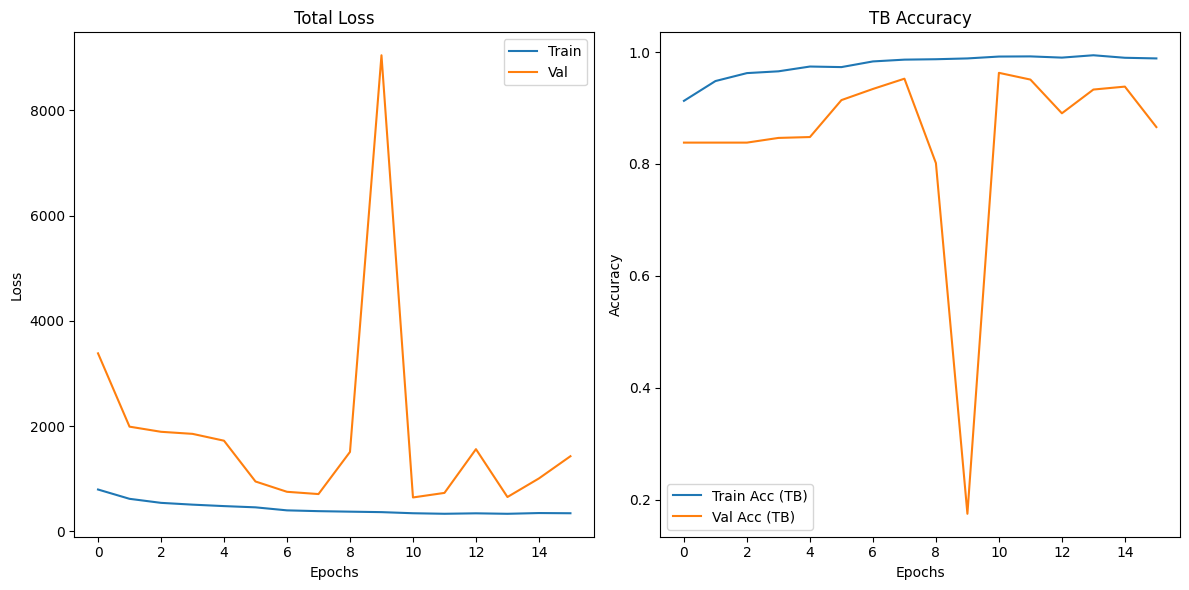

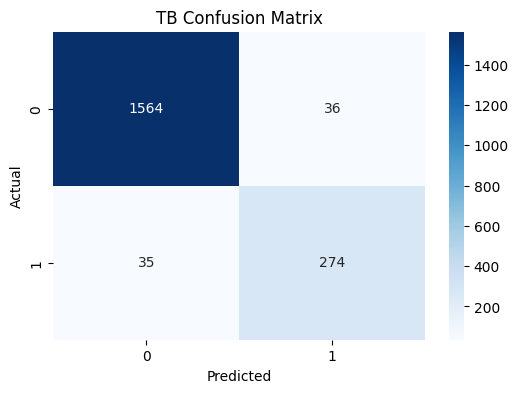

In [4]:
# --- Step 6: Evaluation ---
preds = model.predict(X_val)
preds_tb = np.argmax(preds[0], axis=1)
true_tb = np.argmax(y_tb_val, axis=1)
preds_bbox = preds[1]
true_bbox = y_bbox_val
preds_severity = np.argmax(preds[2], axis=1)
true_severity = np.argmax(y_severity_val, axis=1)

print("\n--- TB Classification ---")
print("Accuracy:", accuracy_score(true_tb, preds_tb))
print("Precision:", precision_score(true_tb, preds_tb))
print("Recall:", recall_score(true_tb, preds_tb))
print("F1-Score:", f1_score(true_tb, preds_tb))
print("Classification Report:\n", classification_report(true_tb, preds_tb))

print("\n--- BBox Regression ---")
print("MSE:", mean_squared_error(true_bbox, preds_bbox))

print("\n--- Severity Classification ---")
print("Accuracy:", accuracy_score(true_severity, preds_severity))
print("Precision:", precision_score(true_severity, preds_severity, average='weighted'))
print("Recall:", recall_score(true_severity, preds_severity, average='weighted'))
print("F1-Score:", f1_score(true_severity, preds_severity, average='weighted'))
print("Classification Report:\n", classification_report(true_severity, preds_severity))

# --- Step 7: Plots ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['tb_output_accuracy'], label='Train Acc (TB)')
plt.plot(history.history['val_tb_output_accuracy'], label='Val Acc (TB)')
plt.title('TB Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# --- Step 8: Confusion Matrix ---
cm = confusion_matrix(true_tb, preds_tb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('TB Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [5]:
# --- Step 9: Save the model ---
model.save('/kaggle/working/model_7_Resnet50.h5')